# Notebook 2 of the eLetter response to Hubbard & Bradley

In this notebook, we evaluate how likely it is that noise in individual stacks combine constructively to produce a precursory exponential-like signal similar to the one we find before large earthquakes (Figure 2 in Bletery and Nocquet, 2023). This comes in complement of the test provided in the supplementary material of the article, in which we drew 100,000 random time windows of noise, apply the stacking procedure and count how frequently we obtain a global stack exhibiting an exponential-like signal similar to the one we observe in Figure 2 of the article (scripts of this test available here: https://doi.org/10.5281/zenodo.8064086) 

In [1]:
# Library cell

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.fftpack import fft, ifft

In [2]:
# Variables declaration cell

nsample = 576               # Numbmer of samples in the time series
mu=29353000000              # Shear modulus
L, W = 1, 1                 # Length and Width of the pre-slip area (in km)
wd = 22                     # Window duration of the moving average (in samples)
      
nd = int(nsample/2)
t = np.arange(-48-1/24,0-1/24,1/12)
M = mu * L*1000 * W*1000 

data_byEQ_dir = 'data_byEQ'                                  # Directory where the time series are stored
leq_file = glob(data_byEQ_dir+"/20*_MW_*/dot_product_stack.txt")  # Earthquake list

In [3]:
# Load dot product stacks for each earthquake

eq_stack, eq_stack_E, eq_stack_N, Nst, sg1, sg2, eq_dir  = [], [], [], [], [], [], []

for eq_file in leq_file:
    eq = eq_file.split('/')[-2]
    eq_dir.append(eq)
    eq_stack.append(np.genfromtxt(eq_file))
    sigmag2 = np.atleast_1d(np.genfromtxt(eq_file.split('/')[0]+'/'+eq+'/sigmag2.txt'))
    sigmaj2 = np.atleast_1d(np.genfromtxt(eq_file.split('/')[0]+'/'+eq+'/sigmaj2.txt'))
    Nst.append(len(sigmag2))
    if len(sigmag2)>1:
        sg1.append(sum(np.divide(np.sqrt(sigmag2),sigmaj2)))   
        sg2.append(sum(np.divide(sigmag2,sigmaj2)))
    else:
        sg1.append(float(np.divide(np.sqrt(sigmag2[0]),sigmaj2[0])))
        sg2.append(float(np.divide(sigmag2[0],sigmaj2[0])))

stack = sum(eq_stack)
Sg = sum(sg2)
stack_moment = M * stack / Sg

Let's start from the begining and plot the global stack (Figure 2A in Bletery and Nocquet, 2023):

Text(0.5, 1.0, 'Global stack')

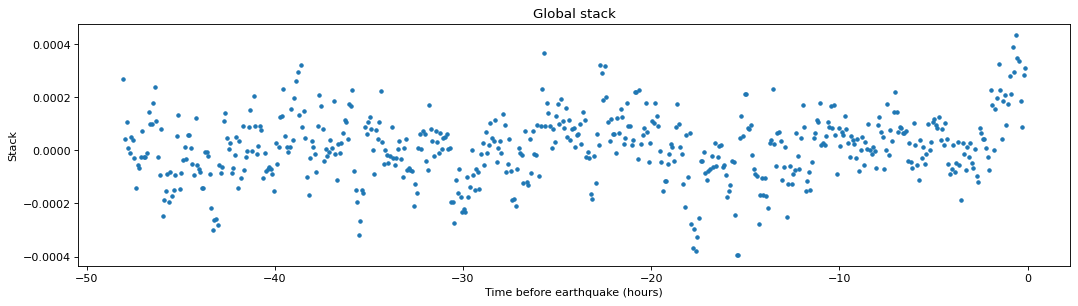

In [4]:
# Plot the global stack (Figure 2A)

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack')

The increasing trend in the last few hours of the stack is not orders of magnitude above the noise level but is visually compelling. The time serie is still rather noisy. One way to lower the noise level at high frequency is to apply a moving average (Figure 2B in Bletery and Nocquet, 2023):

In [5]:
# Let's define a moving average function

def moving_average(wd,time_series):
    Nsma = len(time_series) - wd    # Number of samples in the moving average time series
    N0 = Nsma - 24                  # Number of samples of the moving average unafected by the last 2 hours
    SMA = np.zeros(Nsma)
    for i in range(Nsma):
        SMA[i] = np.mean(time_series[i:i+wd])
    max_sma = max(SMA[0:N0])        # Maximum of the moving average excluding the last 2 hours
    return SMA, max_sma

Last point of the moving average is 1.82 times larger than the maximum in the 2 days before (r = 1.82)
The last 23 points of the moving average are monotonically increasing (n = 23)


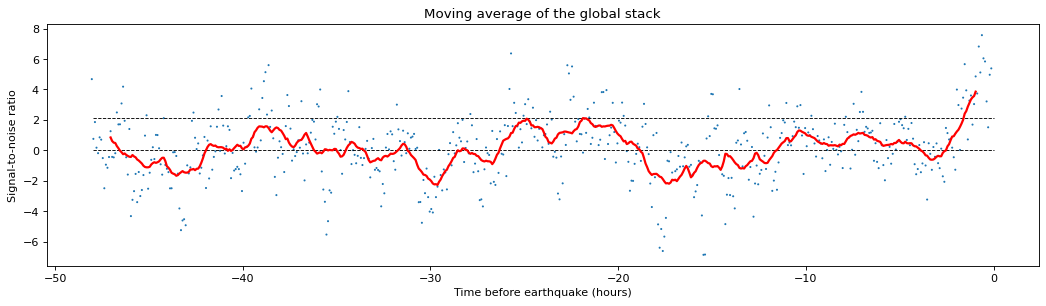

In [6]:
# Calculate a moving average (windows of 1h50min with wd=22) and plot it (Figure 2B)

Nsma = len(stack) - wd          # Number of samples in the moving average time series
N0 = Nsma - 24                  # Number of samples of the moving average unafected by the last 2 hours
tsma = [0]*Nsma

[SMA,max_sma] = moving_average(wd,stack)
for i in range(Nsma):
    tsma[i] = -48+(i+(1+wd)/2)*5/60
std_sma = np.std(SMA[0:N0]) # standard deviation of the moving average excluding the last 2 hours

plt.figure(figsize=(16, 4), dpi=80)
plt.plot([-48,0],[0,0],'k--',linewidth=0.8)
plt.plot([-48,0],[max_sma,max_sma]/std_sma,'k--',linewidth=0.8)
plt.scatter(t,stack/std_sma,s=[0.7 for n in range(len(t))])
plt.plot(tsma,SMA/std_sma,'r-',linewidth=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Signal-to-noise ratio')
plt.title('Moving average of the global stack')

print('Last point of the moving average is '+str(round(SMA[-1]/max_sma,2))+' times larger than the maximum in the 2 days before (r = 1.82)')
print('The last '+str(len(SMA) - np.where(np.diff(SMA)<=0)[0][-1]-2)+' points of the moving average are monotonically increasing (n = 23)')

The purpose of this notebook is to quantify how likely it is to obtain a trend simiar to the last 2 hours of the red curve above by constructively stacking correlated noise. To do so, we are going to compute the Fourrier transform of every earthquake stack and generate many surrogate stacks by shuffling the phase. The procedure ensures that the structure of the correlated noise in earthquake stack time series has the same statistical properties than the real ones. Then, we will statistically evaluate the likelihood to observe a signal similar to the preslip proposed in Bletery and Nocquet (2023).

In [7]:
# Let's define a function to shuffle the phase

def phaseScrambleTS(ts):   
    fs = fft(ts)
    pow_fs = np.abs(fs) ** 2.
    phase_fs = np.angle(fs)
    phase_fsr = phase_fs.copy()
    if ts.shape[0] % 2 == 0:
        phase_fsr_lh = phase_fsr[1:int(phase_fsr.shape[0]/2)]
    else:
        phase_fsr_lh = phase_fsr[1:int( phase_fsr.shape[0]/2) + 1]
    np.random.shuffle(phase_fsr_lh)
    if ts.shape[0] % 2 == 0:
        phase_fsr_rh = -phase_fsr_lh[::-1]
        phase_fsr = np.concatenate((np.array((phase_fsr[0],)), phase_fsr_lh,
                                    np.array((phase_fsr[int(phase_fsr.shape[0]/2)],)),
                                    phase_fsr_rh))
    else:
        phase_fsr_rh = -phase_fsr_lh[::-1]
        phase_fsr = np.concatenate((np.array((phase_fsr[0],)), phase_fsr_lh, phase_fsr_rh))
    fsrp = np.sqrt(pow_fs) * (np.cos(phase_fsr) + 1j * np.sin(phase_fsr))
    tsrp = ifft(fsrp)
    if not np.allclose(tsrp.imag, np.zeros(tsrp.shape)):
        max_imag = (np.abs(tsrp.imag)).max()
        imag_str = '\nNOTE: a non-negligible imaginary component was discarded.\n\tMax: {}'
        print(imag_str.format(max_imag))
    return tsrp.real

In [8]:
# Simulate earthquake stacks 

n_shuffle = 10000
n_eq = len(eq_stack)

# Running this cell is rather long. You can skip it and load the npy file in the next cell.
# Comment from here if you want to do that.
ts_shuffled = np.zeros([n_eq,n_shuffle,nsample])

for i in range(n_eq):
    for j in range(n_shuffle):
        ts_shuffled[i,j,:] = phaseScrambleTS(eq_stack[i])
    
np.save('simulated_stacks.npy',ts_shuffled)        

In [9]:
#ts_shuffled = np.load('simulated_stacks.npy')  # Uncomment this line if you skipped the previous cell

nstack = 100000
combination = np.random.randint(0,n_shuffle,size=nstack*n_eq).reshape(nstack,n_eq)
shuffled_stack = np.zeros([nstack,nsample])

for i in range(nstack):
    for j in range(n_eq):
        shuffled_stack[i,:] = shuffled_stack[i,:] + ts_shuffled[j,combination[i,j],:]

Text(0.5, 0, 'Time before earthquake (hours)')

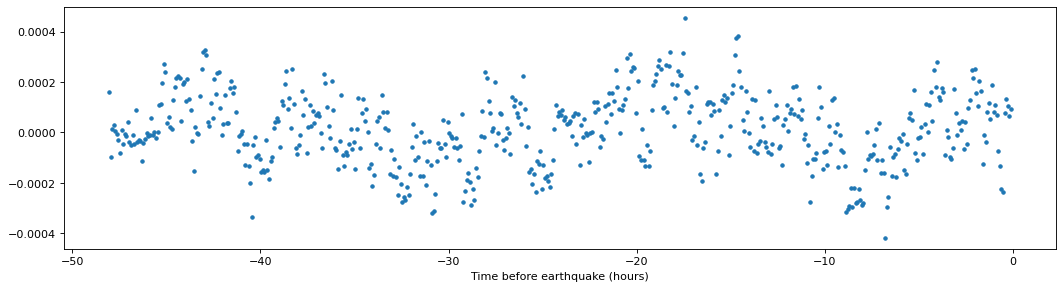

In [10]:
# Plot a random stack to check if it looks alright

ns = np.random.randint(nstack)
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,shuffled_stack[ns,:],'.')
plt.xlabel('Time before earthquake (hours)')

In [11]:
# Get some statistics on the ratio r between the last point of the moving average and the maximum on the 2 days
# before, and on the number of monotonically increasing points at the end of the moving average

r, nup = np.zeros([nstack,1]), np.zeros([nstack,1])

for i in range(nstack):
    [shuffled_mstack,max_shuffled_mstack] = moving_average(wd,shuffled_stack[i,:])
    r[i] = shuffled_mstack[-1] / max_shuffled_mstack
    nup[i] = len(SMA) - np.where(np.diff(shuffled_mstack)<=0)[0][-1]-2

Let's plot the histogram of the ratio r between the last point of the moving average and the maximum on the 2 previous days. The value of r for the global stack before the earthquakes (r = 1.82) is higlighted in red:

Text(0.5, 1.0, 'Histogram of the ratio (r) between the last point of the moving average \n and the maximum on the 2 previous days')

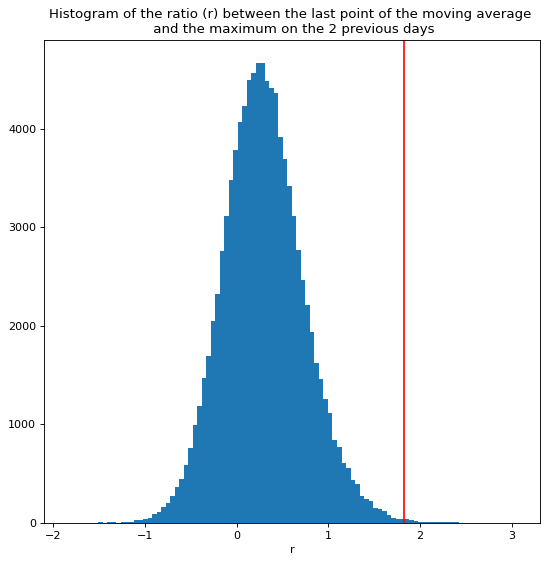

In [12]:
# Plot histograms of r

plt.figure(figsize=(8, 8), dpi=80)
plt.hist(r,100)
plt.axvline(x=1.82,c='red')
plt.xlabel('r')
plt.title('Histogram of the ratio (r) between the last point of the moving average \n and the maximum on the 2 previous days')

Let's do the same for the number n of monotonically increasing points at the end of the moving average (n = 23 in Figure 2B):

Text(0.5, 1.0, 'Histogram of the number (n) of monotonically increasing points \n at the end of the moving average')

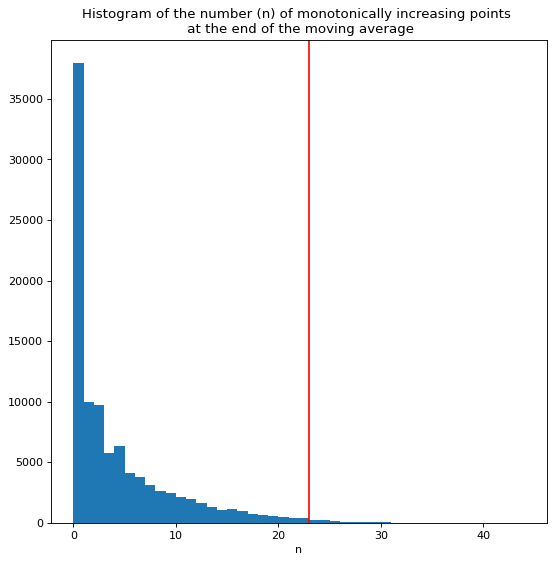

In [13]:
# Plot histogram of the number of monotonically increasing points at the end of the moving average

plt.figure(figsize=(8, 8), dpi=80)
plt.hist(nup,int(max(nup)[0]))
plt.axvline(x=23,c='red')
plt.xlabel('n')
plt.title('Histogram of the number (n) of monotonically increasing points \n at the end of the moving average')

Let's now calculate the probabilities of r >= 1.82 and n >= 23:

In [14]:
# Compute the probabilities to obtain similar statistics than the ones found on the global by constructively
# stacking noise

Ir = np.where(r>=1.82)[0]
p_r = 100 * len(Ir) / nstack  
Inup = np.where(nup>=23)[0]
p_nup = 100 * len(Inup) / nstack
Irn = np.where((r>=1.82) & (nup>=23))[0]
p_rn = 100 * len(Irn) / nstack

print('The probability of r >= 1.82 is '+str(p_r)+' %')
print('The probability of n >= 23 is '+str(p_nup)+' %')
print('The combined probability of the 2 propositions above is '+str(p_rn)+' %')

The probability of r >= 1.82 is 0.159 %
The probability of n >= 23 is 0.953 %
The combined probability of the 2 propositions above is 0.02 %


We obtain probabilities very similar to the ones obtained in the article on (empirical) random time series, and very similar histograms (see Figure S9), confirming the statistical significance of the signal. 

# Conclusion

The probability to obtain a signal similar to the one we observe before the earthquakes by constructively summing noise is well below 1 %, making the possibility that the signal arises from correlated noise very unlikely.